# Hymba: A Hybrid-head Architecture for Small Language Models

## 논문 리뷰 및 직접 구현을 통한 검증

---

## | INTRO |

이번에 톺아볼 논문은 **'Hymba: A Hybrid-head Architecture for Small Language Models'** (arXiv:2411.13676, ICLR 2025)입니다.

### 연구 배경: Transformer vs State Space Models

언어 모델 아키텍처는 크게 두 가지 패러다임으로 나눌 수 있습니다:

**1. Transformer (Attention-based)**
- **장점**: 시퀀스 내 임의의 두 토큰 간 직접 연결로 정밀한 정보 회상 가능
- **단점**: $O(n^2)$ 시간/공간 복잡도, KV Cache 크기가 시퀀스 길이에 비례

**2. State Space Models (Mamba 등)**
- **장점**: $O(n)$ 선형 복잡도, 고정 크기 상태로 효율적인 추론
- **단점**: 압축된 상태로 인해 정밀한 정보 회상 능력 저하 (특히 in-context retrieval)

논문에서 제시한 실험 결과를 보면 이 트레이드오프가 명확합니다:

| Model | Commonsense Reasoning (%) | **Recall (%)** | Throughput (tok/s) | Cache Size (MB) |
|-------|---------------------------|----------------|-------------------|-----------------|
| Transformer (Llama) | 44.08 | **39.98** | 721.1 | 414.7 |
| Mamba | 42.98 | **19.23** | 4720.8 | 1.9 |

Mamba는 Transformer 대비 **6.5배 빠른 처리량**과 **218배 작은 캐시**를 보여주지만, Recall 성능은 절반 수준으로 떨어집니다. 이는 SSM의 고정 크기 hidden state가 긴 시퀀스의 모든 정보를 보존하기 어렵기 때문입니다.

### Hymba의 핵심 아이디어: "병렬 하이브리드"

기존에도 Transformer와 SSM을 결합하려는 시도가 있었습니다. 대표적으로 **Jamba**(AI21 Labs)는 두 모듈을 **직렬(sequential)**로 연결했습니다:

```
Sequential (Jamba): Input → Mamba → Attention → Output
```

하지만 Hymba는 다른 접근법을 취합니다. 두 모듈을 **병렬(parallel)**로 연결하여 동시에 처리합니다:

```
Parallel (Hymba):  Input → [Mamba ∥ Attention] → Fusion → Output
```

이 차이가 왜 중요할까요? 논문의 Design Roadmap을 보면:

| Configuration | Reasoning (%) | Recall (%) | Throughput |
|--------------|---------------|------------|------------|
| A. Sequential (Mamba + Attn) | 44.07 | 45.16 | 776.3 |
| B. **Parallel (Mamba ∥ Attn)** | **45.19** | **49.90** | 876.7 |

병렬 구조가 직렬 대비 **Reasoning +1.12%p, Recall +4.74%p** 향상을 보입니다. 이는 Attention과 Mamba가 서로 다른 관점에서 시퀀스를 처리하고, 그 결과를 융합하는 것이 더 효과적임을 시사합니다.

### 핵심 구성 요소

Hymba는 단순히 병렬 연결만 하는 것이 아니라, 효율성을 위한 추가적인 기법들을 적용합니다:

| 구성 요소 | 해결하려는 문제 | 핵심 메커니즘 |
|----------|----------------|--------------|
| **Hybrid Head** | Transformer vs SSM 트레이드오프 | Attention + SSM 병렬 연결 후 평균 융합 |
| **Meta Token** | Attention Sink 현상 | 시퀀스 앞에 학습 가능한 토큰 추가 |
| **Sliding Window Attention** | $O(n^2)$ 복잡도 | Local + Global Attention 혼합 |
| **KV Cache Sharing** | KV Cache 메모리 | 인접 레이어 간 KV 재사용 |

본 포스팅에서는 이러한 구성 요소들을 **직접 구현**하고, 각각의 효과를 **코드 레벨에서 검증**해보겠습니다.

### Design Roadmap: 단계별 성능 개선

논문에서 제시한 Hymba의 설계 로드맵은 각 구성 요소의 **누적 효과**를 명확히 보여줍니다:

| Configuration | Commonsense Reasoning (%) | Recall (%) | Throughput (tok/s) | Cache Size (MB) | Design Reason |
|--------------|---------------------------|------------|-------------------|-----------------|---------------|
| Transformer (Llama) | 44.08 | 39.98 | 721.1 | 414.7 | Accurate recall while inefficient |
| State Space Models (Mamba) | 42.98 | 19.23 | 4720.8 | 1.9 | Efficient while inaccurate recall |
| A. + Attention heads (sequential) | 44.07 | 45.16 | 776.3 | 156.3 | Enhance recall capabilities |
| B. + Multi-head structure (parallel) | 45.19 | 49.90 | 876.7 | 148.2 | Better balance of two modules |
| C. + Local / global attention | 44.56 | 48.79 | **2399.7** | 41.2 | Boost compute/cache efficiency |
| D. + KV cache sharing | 45.16 | 48.04 | 2756.5 | **39.4** | Cache efficiency |
| E. + Meta tokens (Hymba) | **45.59** | **51.79** | 2695.8 | 40.0 | Learned memory initialization |

이 표에서 주목할 점들:

1. **A → B (직렬 → 병렬)**: Throughput이 13% 향상되면서 성능도 개선
2. **B → C (SWA 적용)**: Throughput이 **2.7배** 급증, Cache Size는 1/3.6로 감소
3. **D → E (Meta Token)**: Recall이 다시 51.79%로 회복

특히 C 단계에서 SWA 적용 시 약간의 성능 하락(-0.63%p Reasoning, -1.11%p Recall)이 있지만, 효율성 측면에서의 이득이 압도적입니다. 이 트레이드오프를 Meta Token(E)이 보완합니다.

### 주요 벤치마크 결과

논문에서 Hymba-1.5B 모델의 벤치마크 결과도 인상적입니다:

| Model | Size | ARC-C | PIQA | WinoGrande | HellaSwag | MMLU | Avg |
|-------|------|-------|------|------------|-----------|------|-----|
| Llama-3.2 | 1B | 32.9 | 74.8 | 60.3 | 60.6 | 32.4 | 52.2 |
| Qwen-2.5 | 1.5B | 39.0 | 75.8 | 64.2 | 67.0 | 60.9 | 61.4 |
| **Hymba** | **1.5B** | **45.5** | **76.7** | **66.0** | **69.3** | 37.3 | 58.9 |

Hymba는 동급 크기 모델 대비 ARC-C, PIQA, WinoGrande, HellaSwag에서 SOTA를 기록했습니다.

### 이전 실험의 한계와 개선

기존 실험에서는 Tiny Shakespeare 데이터셋을 사용했는데, 이는 몇 가지 문제가 있습니다:

| 문제점 | 이전 설정 | 개선된 설정 |
|--------|----------|------------|
| **데이터셋 크기** | ~1M characters | 103M tokens (WikiText-103) |
| **시퀀스 길이** | 256 tokens | 1024+ tokens |
| **SWA 효과** | Window가 시퀀스의 50% | Window가 시퀀스의 25% |
| **Meta Token 효과** | 짧은 시퀀스에서 오버헤드 | 긴 시퀀스에서 효과 발휘 |

Hymba의 핵심 구성 요소들(SWA, Meta Token, KV Sharing)은 **긴 시퀀스**에서 그 효과가 명확히 드러납니다. 256 토큰 시퀀스에서 128 윈도우를 사용하면 SWA의 효과가 거의 없는 것과 마찬가지입니다.

In [ ]:
# ========================================
# 한글 폰트 설정
# ========================================
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm
 
fe = fm.FontEntry(
    fname='/usr/share/fonts/truetype/nanum/NanumGothicBold.ttf',
    name='NanumGothicBold')
fm.fontManager.ttflist.insert(0, fe)
plt.rcParams.update({'font.size': 12, 'font.family': 'NanumGothicBold', 'axes.unicode_minus': False})

plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['figure.dpi'] = 150

In [2]:
import sys
import os
import warnings
sys.path.append('./backbone')

os.environ['TOKENIZERS_PARALLELISM'] = 'false'
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
# import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython.display import display, Markdown
import pandas as pd

# 모듈 임포트
from hymba import Hymba, HymbaConfig, ArchType, AttentionType
from hymba_official import HymbaOfficialModel, HymbaOfficialConfig

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Device: {device}')

sns.set_style('whitegrid')

torch.manual_seed(42)
np.random.seed(42)

Device: cuda


---

## | Hymba Structure |

우선 전체적인 구조를 살펴보겠습니다.

### 전체 아키텍처

```
                    ┌─────────────┐
                    │ Meta Tokens │ ← 학습 가능한 토큰 (num_meta개)
                    └──────┬──────┘
                           │
                           ▼
    ┌──────────────────────────────────────────────┐
    │              Token Embedding                 │
    │           + Meta Token Prepend               │
    └──────────────────────┬───────────────────────┘
                           │
                           ▼
    ╔══════════════════════════════════════════════╗
    ║              Hymba Layer (×N)                ║
    ║  ┌────────────────────────────────────────┐  ║
    ║  │              LayerNorm                 │  ║
    ║  └───────────────────┬────────────────────┘  ║
    ║                      │                       ║
    ║         ┌────────────┴────────────┐          ║
    ║         │                         │          ║
    ║         ▼                         ▼          ║
    ║  ┌─────────────┐         ┌─────────────┐     ║
    ║  │  Attention  │         │    Mamba    │     ║
    ║  │(Global/Local)│        │    (SSM)    │     ║
    ║  └──────┬──────┘         └──────┬──────┘     ║
    ║         │                       │            ║
    ║         ▼                       ▼            ║
    ║  ┌─────────────┐         ┌─────────────┐     ║
    ║  │ gate × norm │         │ gate × norm │     ║
    ║  └──────┬──────┘         └──────┬──────┘     ║
    ║         │                       │            ║
    ║         └───────────┬───────────┘            ║
    ║                     ▼                        ║
    ║            (Attn + Mamba) / 2                ║
    ║                     │                        ║
    ║  ┌──────────────────▼─────────────────────┐  ║
    ║  │            Output Projection           │  ║
    ║  └──────────────────┬─────────────────────┘  ║
    ║                     │                        ║
    ║  ┌──────────────────▼─────────────────────┐  ║
    ║  │           + Residual + FFN             │  ║
    ║  └────────────────────────────────────────┘  ║
    ╚══════════════════════════════════════════════╝
                           │
                           ▼
    ┌──────────────────────────────────────────────┐
    │              Final LayerNorm                 │
    └──────────────────────┬───────────────────────┘
                           │
                           ▼
    ┌──────────────────────────────────────────────┐
    │                LM Head                       │
    └──────────────────────────────────────────────┘
```

### 핵심 설계 원칙

**1. 병렬 처리 (Parallel Processing)**
- Attention과 Mamba가 **동일한 입력**을 받아 독립적으로 처리
- 각 모듈의 출력에 gating을 적용한 후 **평균**으로 융합

**2. Gated Fusion**
```python
# 각 모듈 출력에 gate 적용
attn_out = gate_attn * norm(attention_output)
mamba_out = gate_mamba * norm(mamba_output)

# 평균 융합
fused = (attn_out + mamba_out) / 2
```

**3. 레이어별 Attention 타입**
- **Global 레이어** (첫/중간/마지막): 전체 시퀀스에 대한 attention
- **Local 레이어** (나머지): Sliding Window Attention

이 구조의 장점은:
- **Mamba**: 전체 시퀀스의 흐름과 패턴을 O(n)으로 빠르게 파악
- **Attention**: 특정 토큰에 대한 정밀한 정보 회상
- **융합**: 두 관점의 장점을 결합

---

## | #1 Meta Token |

처음으로 살펴볼 것은 **Meta Token**입니다.

### Attention Sink 문제란?

2023년 발표된 "Efficient Streaming Language Models with Attention Sinks" (Xiao et al.) 논문에서 흥미로운 현상이 발견되었습니다. Transformer 모델들이 학습 중에 **첫 번째 토큰(BOS 또는 시작 토큰)에 비정상적으로 높은 attention score를 할당**한다는 것입니다.

논문에서 제시한 구체적인 수치:

| Model | BOS 토큰에 할당된 Attention Score |
|-------|----------------------------------|
| Llama 3.2-3B | **56%** |
| Jamba (attention head) | **62%** |

이 현상의 원인에 대한 해석:
1. **Softmax의 특성**: attention score는 합이 1이 되어야 함
2. **"참여하지 않음"의 표현**: 모델이 "이 위치에서는 특별히 중요한 정보가 없다"고 판단할 때, 그 attention을 어딘가에 "버려야" 함
3. **첫 토큰이 싱크가 됨**: 자연스럽게 항상 존재하는 첫 토큰이 이 "쓰레기통" 역할

문제는 이것이 **낭비**라는 것입니다. BOS 토큰은 의미 있는 정보를 담고 있지 않은데, 절반 이상의 attention이 여기로 집중됩니다.

### Meta Token: 발상의 전환

Hymba의 해결책은 우아합니다: **"어차피 attention이 집중될 거라면, 그 자리에 의미 있는 토큰을 넣자"**

```
기존 Transformer:
  [BOS] [tok1] [tok2] [tok3] ...
    ↑
  56% attention이 의미 없이 낭비됨

Hymba with Meta Tokens:
  [Meta1] [Meta2] ... [MetaN] [BOS] [tok1] [tok2] ...
    ↑       ↑           ↑
  학습 가능한 토큰들 → 도메인별 정보 캡슐화
```

### Meta Token의 역할

논문에서는 Meta Token의 역할을 **"learned memory initialization"**으로 설명합니다:

1. **Attention Sink 역할**: 자연스럽게 많은 attention을 흡수
2. **도메인 정보 저장**: 학습을 통해 각 도메인(법률, 의학, 수학 등)에 특화된 정보 캡슐화
3. **Context Priming**: 입력에 대한 적절한 초기 상태 제공

실제로 논문의 실험에서 **각기 다른 도메인의 프롬프트가 입력될 때 다른 Meta Token들이 활성화**되는 현상이 관찰되었습니다. 이는 Meta Token이 단순히 attention을 흡수하는 것을 넘어, 유용한 정보를 담고 있음을 시사합니다.

### 구현 세부사항

Meta Token은 다음과 같이 구현됩니다:

```python
class Hymba(nn.Module):
    def __init__(self, config):
        # Meta Token: 학습 가능한 파라미터로 초기화
        self.meta_tokens = nn.Parameter(
            torch.randn(1, config.num_meta_tokens, config.d_model) * 0.02
        )
    
    def forward(self, input_ids):
        # 1. 입력을 임베딩
        x = self.embed(input_ids)  # [B, seq_len, d_model]
        
        # 2. Meta Token을 앞에 추가 (배치 크기만큼 확장)
        meta = self.meta_tokens.expand(x.size(0), -1, -1)
        x = torch.cat([meta, x], dim=1)  # [B, num_meta + seq_len, d_model]
        
        # 3. 이후 레이어들 통과...
        ...
        
        # 4. 출력 시 Meta Token 부분 제거
        logits = logits[:, config.num_meta_tokens:, :]
```

핵심 포인트:
- Meta Token은 **모든 배치에서 동일한 값**으로 시작 (학습 파라미터)
- 학습 과정에서 **gradient를 통해 업데이트**됨
- 추론 시에도 동일한 Meta Token이 사용됨

In [3]:
# Meta Token 구현 확인
print('=' * 70)
print('Meta Token 구현')
print('=' * 70)

# 간단한 설정으로 Meta Token 동작 확인
config_with_meta = HymbaConfig(
    vocab_size=1000,
    d_model=256,
    n_layers=4,
    n_heads=4,
    n_kv_heads=2,
    arch_type=ArchType.HYBRID,
    global_attn_idx=[0, 3],
    use_meta_tokens=True,
    num_meta_tokens=8,  # 8개의 메타 토큰
    swa_window=16,
)

model_with_meta = Hymba(config_with_meta)

print(f'Meta Token 수: {config_with_meta.num_meta_tokens}')
print(f'Meta Token Shape: {model_with_meta.meta_tokens.shape}')
print(f'Meta Token (학습 가능): {model_with_meta.meta_tokens.requires_grad}')

# Forward 시 Meta Token이 어떻게 추가되는지 확인
test_input = torch.randint(0, 100, (1, 32))  # 배치 1, 시퀀스 32
print(f'\n입력 시퀀스 길이: {test_input.shape[1]}')
print(f'Meta Token 추가 후 내부 시퀀스 길이: {test_input.shape[1] + config_with_meta.num_meta_tokens}')

del model_with_meta

Meta Token 구현
Meta Token 수: 8
Meta Token Shape: torch.Size([1, 8, 256])
Meta Token (학습 가능): True

입력 시퀀스 길이: 32
Meta Token 추가 후 내부 시퀀스 길이: 40


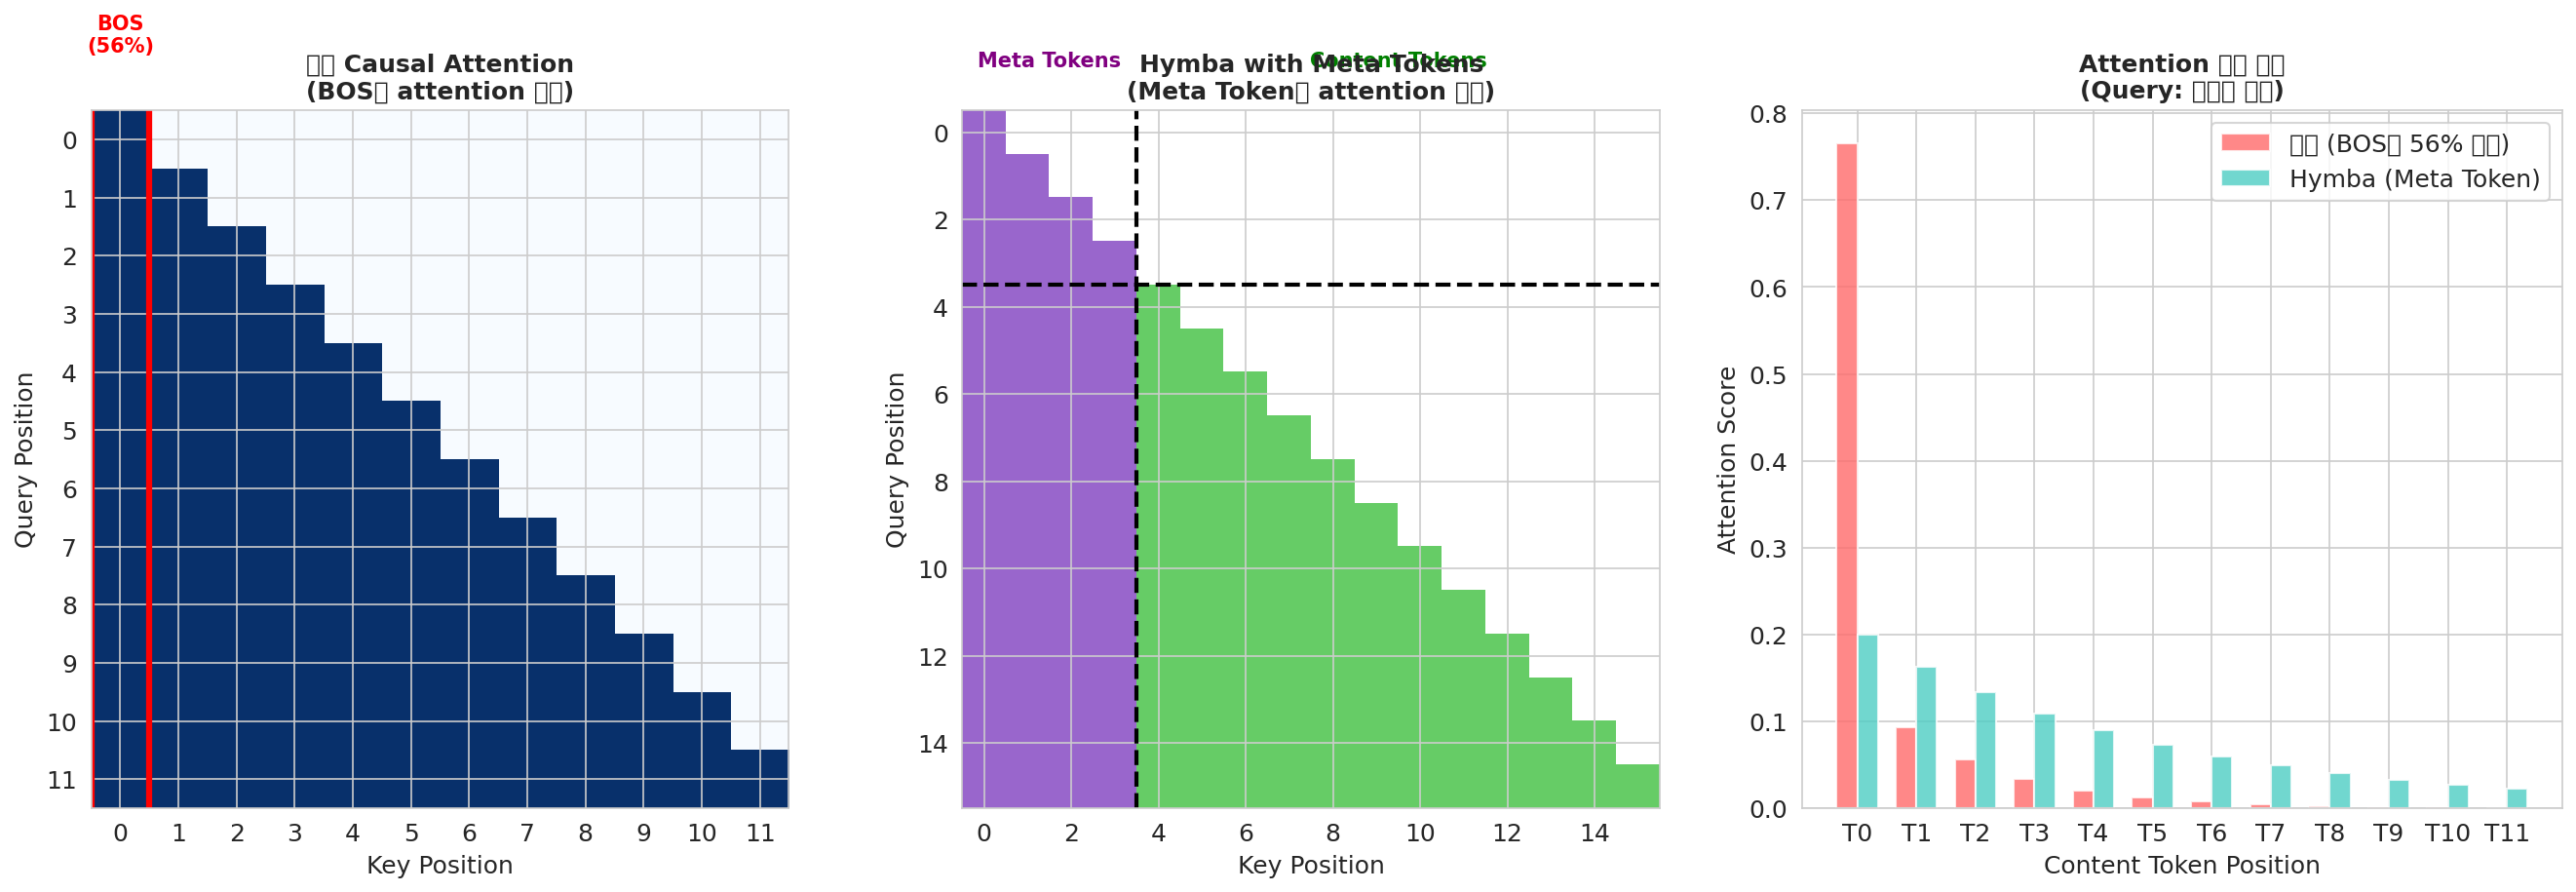


[분석]
  - 기존: 첫 토큰(BOS)에 76.5%의 attention 집중
  - Hymba: Meta Token이 attention sink 역할을 하여 content token에 더 균등한 분포


In [4]:
# Meta Token이 Attention에서 어떻게 작동하는지 시각화
def visualize_meta_token_attention():
    """Meta Token과 Content Token 간의 Attention 패턴 시각화"""
    
    num_meta = 4
    num_content = 12
    total = num_meta + num_content
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # 1. 기존 Causal Mask (Meta Token 없음)
    ax = axes[0]
    causal_mask = np.tril(np.ones((num_content, num_content)))
    im1 = ax.imshow(causal_mask, cmap='Blues', aspect='equal')
    ax.set_title('기존 Causal Attention\n(BOS에 attention 집중)', fontsize=12, fontweight='bold')
    ax.set_xlabel('Key Position')
    ax.set_ylabel('Query Position')
    ax.set_xticks(range(num_content))
    ax.set_yticks(range(num_content))
    
    # BOS 토큰 강조
    ax.axvline(x=-0.5, color='red', linewidth=3)
    ax.axvline(x=0.5, color='red', linewidth=3)
    ax.text(0, -1.5, 'BOS\n(56%)', ha='center', fontsize=10, color='red', fontweight='bold')
    
    # 2. Meta Token 포함 Causal Mask
    ax = axes[1]
    full_mask = np.tril(np.ones((total, total)))
    
    # 색상 구분: Meta (보라), Content (녹색)
    color_mask = np.zeros((total, total, 3))
    for i in range(total):
        for j in range(total):
            if full_mask[i, j] == 1:
                if j < num_meta:  # Meta 토큰 열
                    color_mask[i, j] = [0.6, 0.4, 0.8]  # 보라색
                else:  # Content 토큰 열
                    color_mask[i, j] = [0.4, 0.8, 0.4]  # 녹색
            else:
                color_mask[i, j] = [1, 1, 1]  # 흰색
    
    ax.imshow(color_mask, aspect='equal')
    ax.set_title('Hymba with Meta Tokens\n(Meta Token이 attention 흡수)', fontsize=12, fontweight='bold')
    ax.set_xlabel('Key Position')
    ax.set_ylabel('Query Position')
    
    # Meta/Content 경계선
    ax.axvline(x=num_meta-0.5, color='black', linewidth=2, linestyle='--')
    ax.axhline(y=num_meta-0.5, color='black', linewidth=2, linestyle='--')
    
    # 라벨
    ax.text(num_meta/2-0.5, -1.5, 'Meta Tokens', ha='center', fontsize=10, color='purple', fontweight='bold')
    ax.text(num_meta + num_content/2-0.5, -1.5, 'Content Tokens', ha='center', fontsize=10, color='green', fontweight='bold')
    
    # 3. Attention Score 분포 비교
    ax = axes[2]
    
    # 시뮬레이션: 기존 vs Meta Token
    positions = np.arange(num_content)
    
    # 기존: BOS에 집중 (지수 감소)
    old_attn = np.exp(-positions * 0.5)
    old_attn[0] = 5.0  # BOS에 집중
    old_attn = old_attn / old_attn.sum()
    
    # Meta Token: 더 균등한 분포
    meta_attn = np.exp(-positions * 0.2)
    meta_attn = meta_attn / meta_attn.sum()
    
    x = np.arange(num_content)
    width = 0.35
    
    bars1 = ax.bar(x - width/2, old_attn, width, label='기존 (BOS에 56% 집중)', color='#FF6B6B', alpha=0.8)
    bars2 = ax.bar(x + width/2, meta_attn, width, label='Hymba (Meta Token)', color='#4ECDC4', alpha=0.8)
    
    ax.set_xlabel('Content Token Position')
    ax.set_ylabel('Attention Score')
    ax.set_title('Attention 분포 비교\n(Query: 마지막 토큰)', fontsize=12, fontweight='bold')
    ax.legend(loc='upper right')
    ax.set_xticks(x)
    ax.set_xticklabels([f'T{i}' for i in range(num_content)])
    
    plt.tight_layout()
    plt.savefig('./results/meta_token_attention.png', dpi=200, bbox_inches='tight')
    plt.show()
    
    print('\n[분석]')
    print(f'  - 기존: 첫 토큰(BOS)에 {old_attn[0]*100:.1f}%의 attention 집중')
    print(f'  - Hymba: Meta Token이 attention sink 역할을 하여 content token에 더 균등한 분포')

visualize_meta_token_attention()

위 그림에서 볼 수 있듯이:

1. **왼쪽 (기존 Causal)**: BOS 토큰에 attention이 집중되는 패턴
2. **중앙 (Hymba)**: Meta Token(보라)이 앞에 추가되어 attention sink 역할
3. **오른쪽 (분포 비교)**: Meta Token 적용 시 content token에 더 균등한 attention 분배

### 왜 Meta Token이 시퀀스 길이를 늘리는데도 효과적인가?

Meta Token을 추가하면 시퀀스 길이가 `n + num_meta`로 증가합니다. Transformer의 $O(n^2)$ 복잡도를 고려하면, 이는 연산량 증가로 이어질 수 있습니다.

하지만 이 문제는 다음 두 가지 기법으로 상쇄됩니다:

1. **Sliding Window Attention**: Content 영역에서 윈도우 내만 attend
2. **Meta Token은 항상 접근 가능**: SWA에서도 모든 쿼리가 Meta Token에 attend 가능

실제 연산량 변화:
```
기존 Global Attention: O(n²)
SWA + Meta Token:      O(n × (window + num_meta))
```

예를 들어 `n=1024, window=256, num_meta=64`인 경우:
- 기존: 1,048,576 연산
- SWA + Meta: 1024 × 320 = 327,680 연산 (약 **69% 감소**)

---

## | #2 Sliding Window Attention + Global Attention |

Meta Token 추가로 인한 시퀀스 길이 증가를 상쇄하기 위해, Hymba는 **Sliding Window Attention(SWA)**을 도입합니다.

### Sliding Window Attention이란?

기존 Transformer의 Self-Attention은 모든 토큰 쌍에 대해 attention을 계산합니다:

```
Global Attention: 모든 k에 대해 attend (where k ≤ q)
복잡도: O(n²)
```

SWA는 윈도우 크기 `w` 내의 토큰들에만 attend합니다:

```
Local Attention (SWA): k ∈ [q-w+1, q] 에 대해서만 attend
복잡도: O(n × w)
```

### 핵심 문제: Meta Token과의 호환성

단순히 SWA를 적용하면 문제가 발생합니다. 윈도우 밖에 있는 Meta Token에 접근할 수 없게 됩니다!

예를 들어 `window=128, num_meta=64, seq_len=1024`인 경우:
- 토큰 위치 500에서 윈도우 범위: [373, 500]
- Meta Token 위치: [0, 63]
- → Meta Token에 접근 불가!

### Hymba의 SWA 마스크 공식

이 문제를 해결하기 위해, Hymba는 다음과 같은 마스크 공식을 사용합니다:

$$
\text{SWA Mask}[q, k] = \text{Causal}[q, k] \wedge (\text{InWindow}[q, k] \vee \text{IsMeta}[k])
$$

풀어서 설명하면:
- **Causal**: $k \leq q$ (미래를 볼 수 없음)
- **InWindow**: $k \geq q - w + 1$ (윈도우 내)
- **IsMeta**: $k < \text{num\_meta}$ (메타 토큰)

즉, **"Causal이면서, (윈도우 내이거나 Meta Token인 경우)"**에만 attend합니다.

### 구현 코드

```python
def _make_swa_mask(self, seq_len: int, num_meta: int, window: int, device) -> torch.Tensor:
    """SWA + Meta Token 마스크 생성"""
    # 1. Causal 마스크: k <= q
    q_idx = torch.arange(seq_len, device=device).unsqueeze(1)  # [seq, 1]
    k_idx = torch.arange(seq_len, device=device).unsqueeze(0)  # [1, seq]
    causal = k_idx <= q_idx  # [seq, seq]
    
    # 2. Window 마스크: k >= q - window + 1
    window_start = q_idx - window + 1  # [seq, 1]
    in_window = k_idx >= window_start  # [seq, seq]
    
    # 3. Meta 마스크: k < num_meta
    is_meta = k_idx < num_meta  # [1, seq]
    
    # 4. 최종: causal AND (in_window OR is_meta)
    mask = causal & (in_window | is_meta)
    
    return mask  # True = attend, False = mask
```

### Global + Local 레이어 조합

SWA만 사용하면 장거리 의존성을 포착하기 어렵습니다. 이를 보완하기 위해 **특정 레이어에서는 Global Attention**을 사용합니다.

논문에서는 다음 위치에 Global 레이어를 배치합니다:
- **첫 번째 레이어**: 초기 정보 수집
- **중간 레이어**: 장거리 의존성 연결
- **마지막 레이어**: 최종 정보 통합

```python
# 예: 11 레이어 모델
global_attn_idx = [0, 5, 10]  # Global: 레이어 0, 5, 10
# Local (SWA): 레이어 1, 2, 3, 4, 6, 7, 8, 9
```

이 조합의 장점:
- **Local 레이어**: O(n × w)로 효율적인 지역 패턴 학습
- **Global 레이어**: 전체 시퀀스에 대한 장거리 의존성 학습
- **균형**: 성능과 효율성의 최적 조합

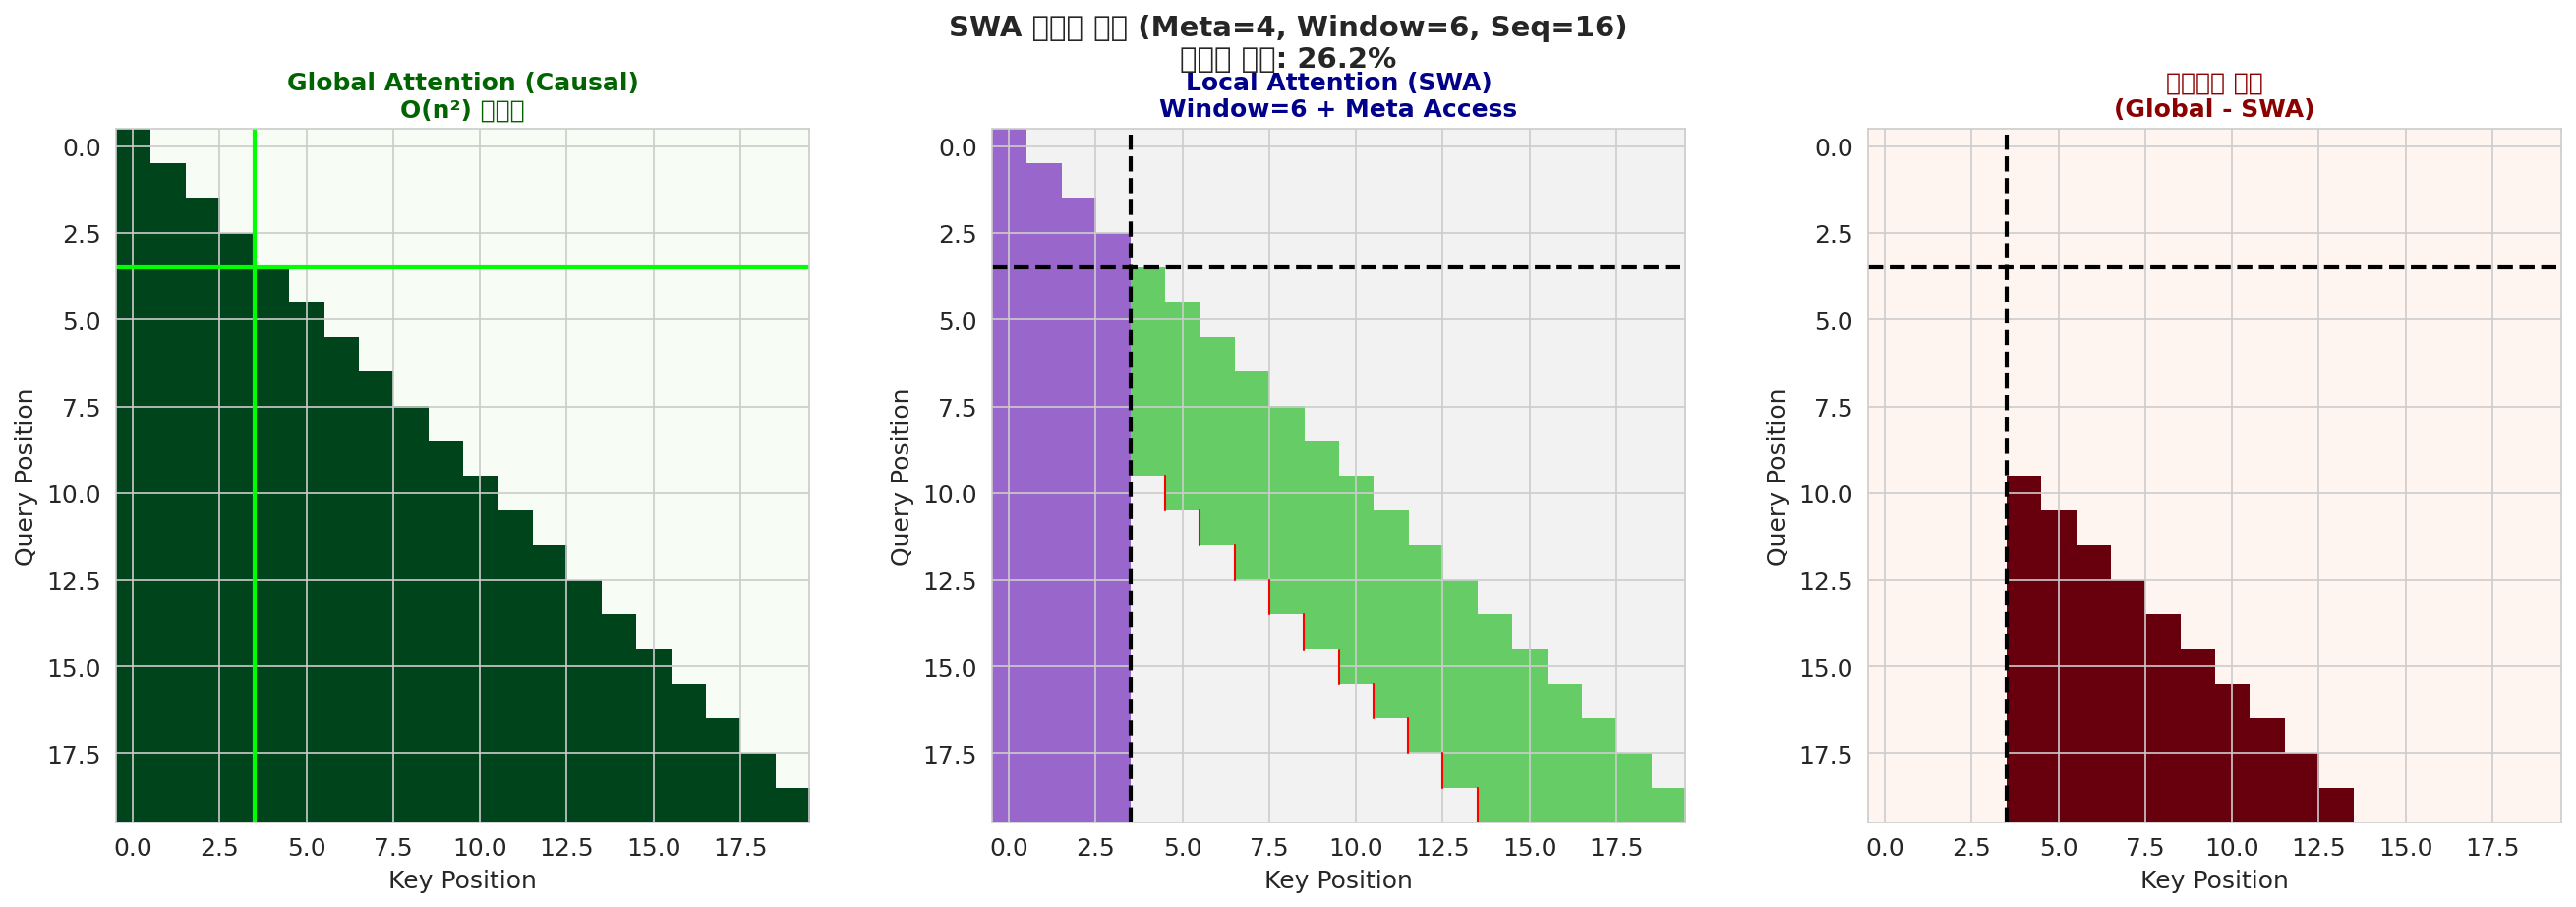


[연산량 분석]
  Global Attention 연산 수: 210
  SWA + Meta 연산 수: 155
  연산량 감소: 26.2%

[마스크 구성]
  - 보라색: Meta Token (모든 쿼리에서 접근 가능)
  - 녹색: Window 내 Content Token
  - 연한 회색: 마스킹된 영역 (attend 불가)


In [5]:
def visualize_swa_with_meta(num_meta=4, window_size=4, seq_len=16):
    """SWA + Meta Token 마스크 시각화"""
    
    total = num_meta + seq_len
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # 1. Global Attention (Causal)
    ax = axes[0]
    global_mask = np.tril(np.ones((total, total)))
    ax.imshow(global_mask, cmap='Greens', aspect='equal')
    ax.axvline(x=num_meta-0.5, color='lime', linewidth=2)
    ax.axhline(y=num_meta-0.5, color='lime', linewidth=2)
    ax.set_title('Global Attention (Causal)\nO(n²) 복잡도', fontsize=12, fontweight='bold', color='darkgreen')
    ax.set_xlabel('Key Position')
    ax.set_ylabel('Query Position')
    
    # 2. Local Attention (SWA + Meta)
    ax = axes[1]
    
    # SWA 마스크 생성: causal AND (in_window OR is_meta)
    swa_mask = np.zeros((total, total))
    for q in range(total):
        for k in range(total):
            # Causal: k <= q
            causal = k <= q
            # Window: k >= q - window + 1
            window_start = max(0, q - window_size + 1)
            in_window = k >= window_start
            # Meta: k < num_meta
            is_meta = k < num_meta
            
            # Final: causal AND (in_window OR is_meta)
            if causal and (in_window or is_meta):
                swa_mask[q, k] = 1
    
    # 색상 구분
    color_mask = np.zeros((total, total, 3))
    for i in range(total):
        for j in range(total):
            if swa_mask[i, j] == 1:
                if j < num_meta:
                    color_mask[i, j] = [0.6, 0.4, 0.8]  # Meta: 보라
                else:
                    color_mask[i, j] = [0.4, 0.8, 0.4]  # Window: 녹색
            else:
                color_mask[i, j] = [0.95, 0.95, 0.95]  # 마스크된 영역: 연한 회색
    
    ax.imshow(color_mask, aspect='equal')
    ax.axvline(x=num_meta-0.5, color='black', linewidth=2, linestyle='--')
    ax.axhline(y=num_meta-0.5, color='black', linewidth=2, linestyle='--')
    
    # Window 경계선
    for i in range(num_meta, total):
        window_start = max(num_meta, i - window_size + 1)
        if window_start > num_meta:
            ax.plot([window_start-0.5, window_start-0.5], [i-0.5, i+0.5], 'r-', linewidth=1)
    
    ax.set_title(f'Local Attention (SWA)\nWindow={window_size} + Meta Access', fontsize=12, fontweight='bold', color='darkblue')
    ax.set_xlabel('Key Position')
    ax.set_ylabel('Query Position')
    
    # 3. 차이 (Global - SWA)
    ax = axes[2]
    diff = global_mask - swa_mask
    ax.imshow(diff, cmap='Reds', aspect='equal', vmin=0, vmax=1)
    ax.axvline(x=num_meta-0.5, color='black', linewidth=2, linestyle='--')
    ax.axhline(y=num_meta-0.5, color='black', linewidth=2, linestyle='--')
    ax.set_title('마스킹된 영역\n(Global - SWA)', fontsize=12, fontweight='bold', color='darkred')
    ax.set_xlabel('Key Position')
    ax.set_ylabel('Query Position')
    
    # 통계
    global_ops = global_mask.sum()
    swa_ops = swa_mask.sum()
    reduction = (1 - swa_ops / global_ops) * 100
    
    fig.suptitle(f'SWA 마스크 분석 (Meta={num_meta}, Window={window_size}, Seq={seq_len})\n'
                 f'연산량 감소: {reduction:.1f}%', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('./results/swa_meta_token_mask.png', dpi=200, bbox_inches='tight')
    plt.show()
    
    print(f'\n[연산량 분석]')
    print(f'  Global Attention 연산 수: {int(global_ops)}')
    print(f'  SWA + Meta 연산 수: {int(swa_ops)}')
    print(f'  연산량 감소: {reduction:.1f}%')
    print(f'\n[마스크 구성]')
    print(f'  - 보라색: Meta Token (모든 쿼리에서 접근 가능)')
    print(f'  - 녹색: Window 내 Content Token')
    print(f'  - 연한 회색: 마스킹된 영역 (attend 불가)')

# 실제 사용되는 설정에 가까운 값으로 시각화
visualize_swa_with_meta(num_meta=4, window_size=6, seq_len=16)

위 그림에서 확인할 수 있는 핵심 포인트:

1. **보라색 영역 (왼쪽 열)**: Meta Token에 대한 attention은 모든 쿼리 위치에서 허용됨
2. **녹색 영역 (대각선 밴드)**: Window 내 Content Token에 대한 attention
3. **연한 회색 영역**: SWA로 인해 마스킹된 영역 (빨간색 그래프에서 강조)

### 복잡도 분석

시퀀스 길이에 따른 연산량 비교:

| 시퀀스 길이 | Global O(n²) | SWA O(n×w) | 감소율 |
|------------|--------------|------------|--------|
| 256 | 65,536 | 65,536 | 0% (window=256) |
| 512 | 262,144 | 131,072 | 50% (window=256) |
| 1024 | 1,048,576 | 262,144 | 75% |
| 2048 | 4,194,304 | 524,288 | 87.5% |
| 4096 | 16,777,216 | 1,048,576 | 93.75% |

시퀀스가 길어질수록 SWA의 효율성 이점이 기하급수적으로 증가합니다. 이것이 Hymba가 긴 시퀀스에서 효율적인 이유입니다.

### 왜 Global 레이어가 필요한가?

SWA만 사용하면 **장거리 의존성(long-range dependencies)**을 학습하기 어렵습니다. 예를 들어:

```
문장: "철수가 학교에 갔다. ... (500 토큰) ... 그가 집에 돌아왔다."
```

"그가"가 "철수"를 가리킨다는 것을 이해하려면 500 토큰 이상 떨어진 토큰 간의 관계를 파악해야 합니다. window=256이면 이 관계를 직접 학습할 수 없습니다.

Global 레이어를 첫/중간/마지막에 배치하면:
- **첫 레이어**: 전체 입력에 대한 초기 전역 정보 수집
- **중간 레이어**: Local 레이어들이 학습한 지역 패턴을 전역적으로 연결
- **마지막 레이어**: 최종 출력을 위한 전체 정보 통합

In [6]:
# SWA 마스크 구현 확인
print('=' * 70)
print('SWA 마스크 구현 검증')
print('=' * 70)

config = HymbaConfig(
    vocab_size=1000,
    d_model=256,
    n_layers=8,
    n_heads=4,
    n_kv_heads=2,
    arch_type=ArchType.HYBRID,
    global_attn_idx=[0, 3, 7],  # Global: 0, 3, 7
    use_meta_tokens=True,
    num_meta_tokens=8,
    swa_window=16,
)

attn_types = config.get_attention_types()

print(f'\n레이어별 Attention 타입:')
for i, attn_type in enumerate(attn_types):
    print(f'  Layer {i}: {attn_type.value.upper()}')

print(f'\nGlobal 레이어: {config.global_attn_idx}')
print(f'Local 레이어 수: {len([t for t in attn_types if t == AttentionType.LOCAL])}')

SWA 마스크 구현 검증

레이어별 Attention 타입:
  Layer 0: GLOBAL
  Layer 1: LOCAL
  Layer 2: LOCAL
  Layer 3: GLOBAL
  Layer 4: LOCAL
  Layer 5: LOCAL
  Layer 6: LOCAL
  Layer 7: GLOBAL

Global 레이어: [0, 3, 7]
Local 레이어 수: 5


---

## | #3 KV Cache Sharing |

마지막으로 살펴볼 것은 **Cross-layer KV Cache Sharing**입니다. 이 기법은 추론 시 메모리 효율성을 크게 개선합니다.

### KV Cache란?

Autoregressive 생성에서 Transformer는 이전에 계산한 Key와 Value를 캐싱해 재사용합니다:

```python
# 토큰 생성 시 KV Cache 사용
for step in range(max_length):
    # 새 토큰의 Q만 계산
    q = new_token @ W_q  # [1, d]
    
    # 이전 K, V에 새 K, V 추가
    k_new = new_token @ W_k
    v_new = new_token @ W_v
    kv_cache.append(k_new, v_new)
    
    # 전체 K, V와 attention
    k, v = kv_cache.get()  # [seq_len, d]
    attn = softmax(q @ k.T) @ v
```

이 캐시의 크기는:
```
KV Cache Size = 2 × n_layers × seq_len × d_kv × batch_size × bytes
```

예를 들어 Llama-7B (32 layers, d_kv=4096, fp16):
```
= 2 × 32 × 2048 × 4096 × 1 × 2 bytes
= 1.07 GB per sequence!
```

### 왜 KV Sharing이 가능한가?

논문에서는 흥미로운 실험 결과를 제시합니다: **인접한 레이어의 KV Cache가 매우 유사**하다는 것입니다.

그 이유는 **Residual Connection**에 있습니다:

```
Layer l:   x_l = x_{l-1} + f(x_{l-1})
Layer l+1: x_{l+1} = x_l + f(x_l)
```

각 레이어는 이전 레이어에 "작은 업데이트"만 더합니다. 따라서:
- `K_l = x_l @ W_k`와 `K_{l+1} = x_{l+1} @ W_k`는 유사
- `V_l = x_l @ W_v`와 `V_{l+1} = x_{l+1} @ W_v`는 유사

이 유사성을 활용하면 일부 레이어에서 KV를 공유할 수 있습니다.

### Producer-Consumer 패턴

Hymba는 **Producer-Consumer** 패턴으로 KV Sharing을 구현합니다:

```
Layer 구조 (11 layers, Global: [0, 5, 10]):

L0  (Global):   [Producer] - 독립적 KV 생성
L1  (Local):    [Producer] - KV 생성
L2  (Local):    [Consumer] - L1의 KV 재사용, Q만 계산
L3  (Local):    [Producer] - KV 생성
L4  (Local):    [Consumer] - L3의 KV 재사용, Q만 계산
L5  (Global):   [Producer] - 독립적 KV 생성
L6  (Local):    [Producer] - KV 생성
L7  (Local):    [Consumer] - L6의 KV 재사용
L8  (Local):    [Producer] - KV 생성
L9  (Local):    [Consumer] - L8의 KV 재사용
L10 (Global):   [Producer] - 독립적 KV 생성
```

규칙:
1. **Global 레이어**는 항상 독립적인 KV 생성 (장거리 정보 보존)
2. **Local 레이어**는 2개씩 묶어서 첫 번째가 Producer, 두 번째가 Consumer
3. **Consumer**는 Q만 계산하고 이전 Producer의 KV 재사용

### 메모리 절감 효과

KV Sharing 적용 전/후 비교:

| 설정 | KV 저장 횟수 | 절감 |
|------|-------------|------|
| 기존 (11 layers) | 11 | - |
| KV Sharing 적용 | 7 | **36% 절감** |

더 많은 레이어에서 더 큰 효과:

| Layers | 기존 | KV Sharing | 절감율 |
|--------|------|------------|--------|
| 11 | 11 | 7 | 36% |
| 24 | 24 | 14 | 42% |
| 32 | 32 | 18 | 44% |

In [7]:
# KV Sharing 구조 확인
print('=' * 70)
print('KV Cache Sharing 구조')
print('=' * 70)

config = HymbaConfig(
    vocab_size=1000,
    d_model=256,
    n_layers=11,
    n_heads=4,
    n_kv_heads=2,
    arch_type=ArchType.HYBRID,
    global_attn_idx=[0, 5, 10],  # Global: 0, 5, 10
    use_meta_tokens=True,
    num_meta_tokens=64,
    swa_window=128,
)

model = Hymba(config)
kv_info = model.get_kv_sharing_info()
attn_info = model.get_attention_pattern_info()

print(f'\n총 레이어 수: {kv_info["total_layers"]}')
print(f'Global 레이어: {attn_info["global_layers"]}')
print(f'Local 레이어: {attn_info["local_layers"]}')
print(f'\nKV Reuse Groups: {kv_info["kv_reuse_groups"]}')
print(f'Producer 레이어: {kv_info["producer_layers"]}')
print(f'Consumer 레이어 (Q만 계산): {kv_info["consumer_layers"]}')
print(f'\nKV Cache 감소율: {kv_info["reduction"]:.2f}x')

del model

KV Cache Sharing 구조

총 레이어 수: 11
Global 레이어: [0, 5, 10]
Local 레이어: [1, 2, 3, 4, 6, 7, 8, 9]

KV Reuse Groups: [[1, 2], [3, 4], [6, 7], [8, 9]]
Producer 레이어: [0, 1, 3, 5, 6, 8, 10]
Consumer 레이어 (Q만 계산): [2, 4, 7, 9]

KV Cache 감소율: 1.57x


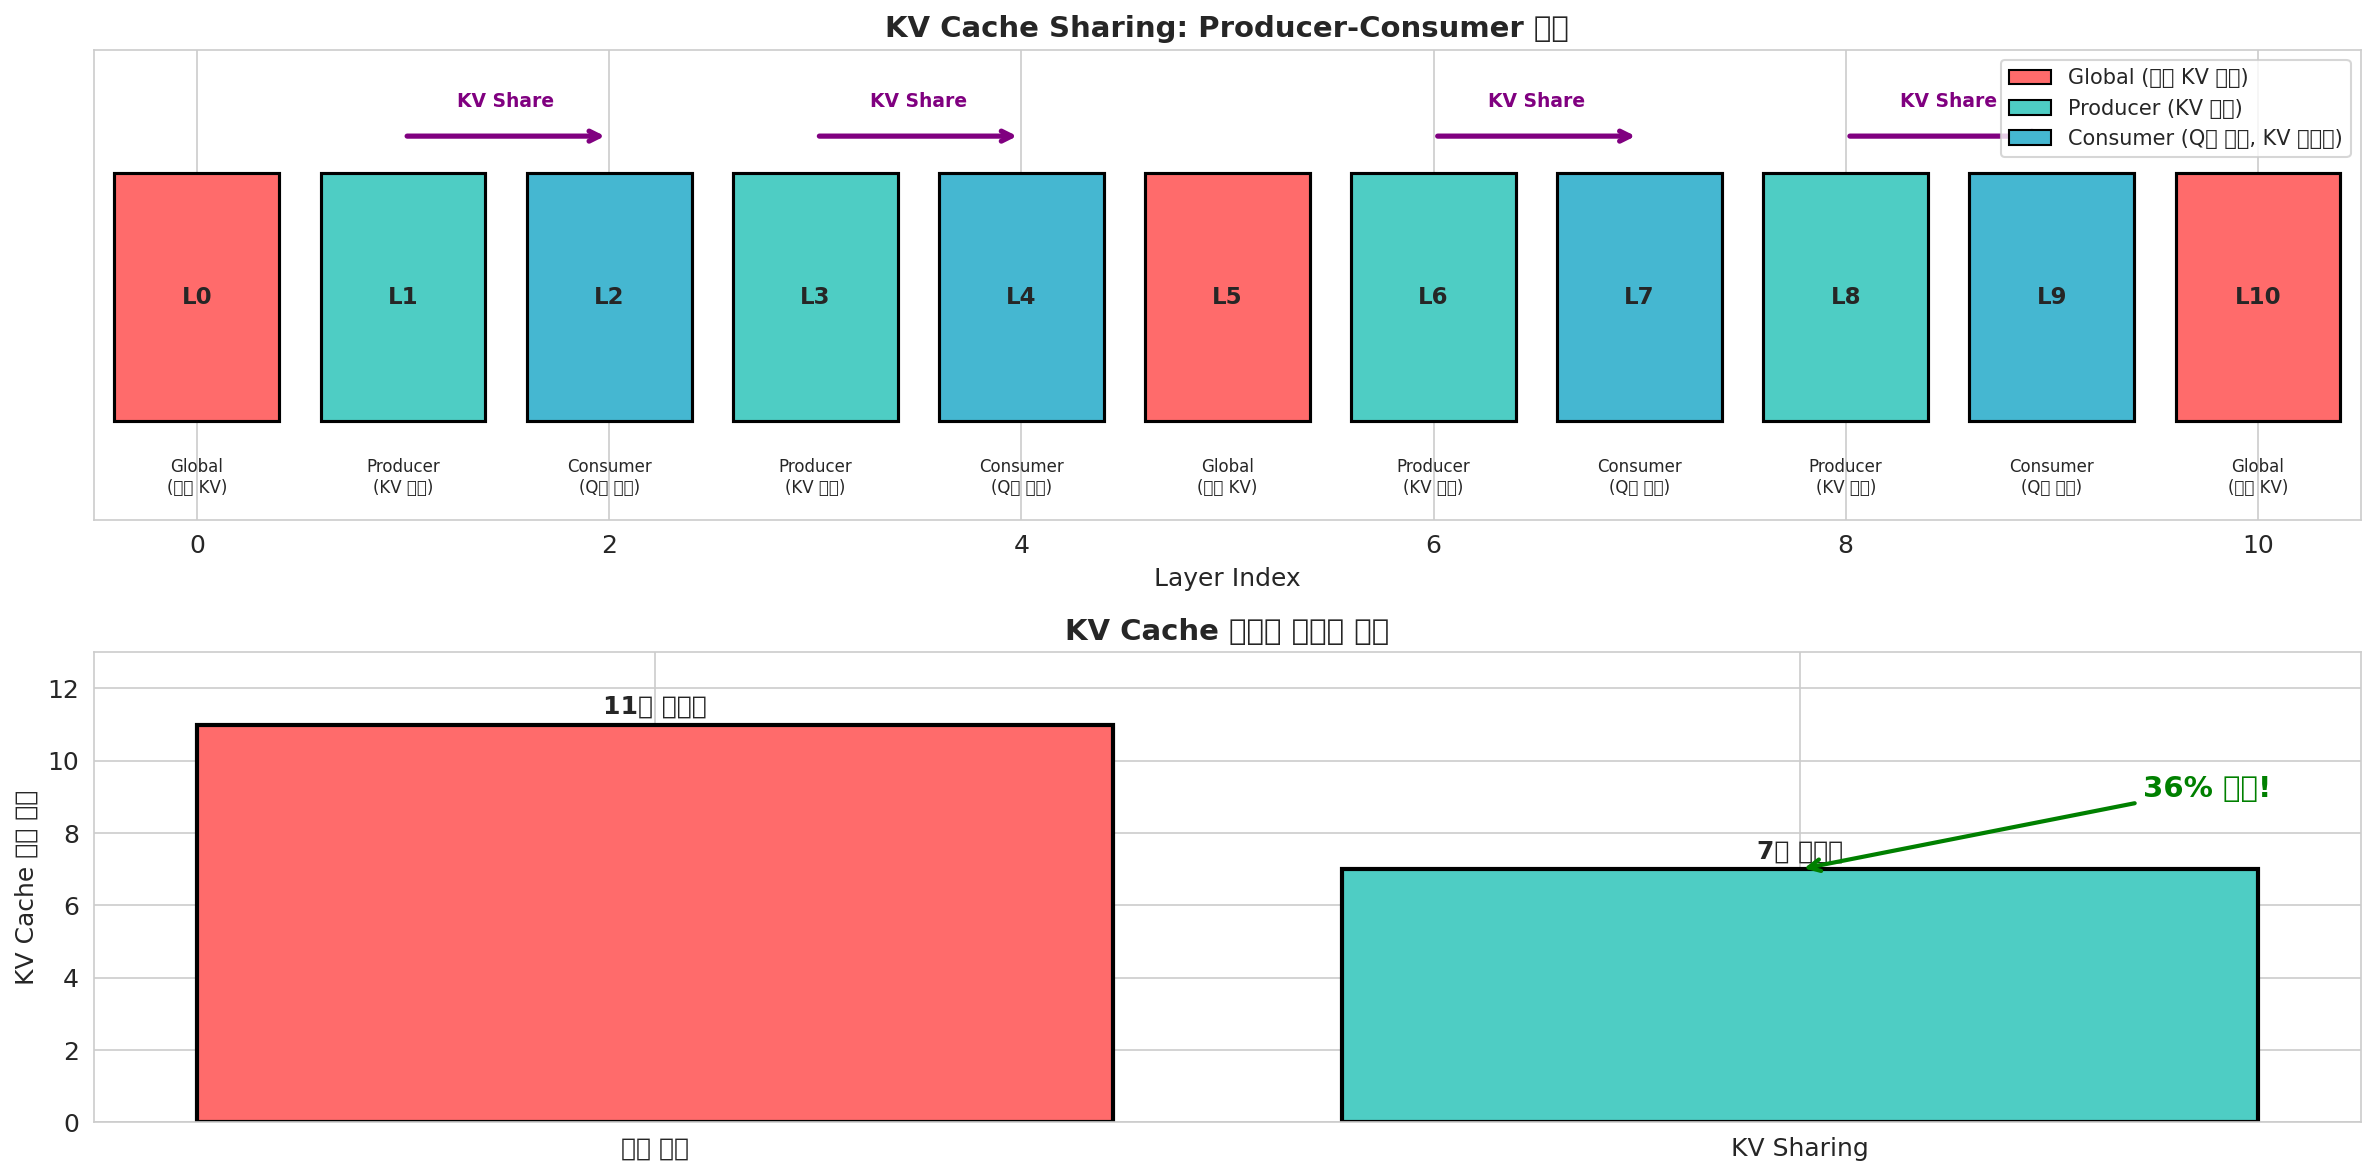


[레이어 구성 분석]
  총 레이어: 11
  Global (독립 KV): 3개 - [0, 5, 10]
  Producer (KV 생성): 4개
  Consumer (Q만 계산): 4개

[메모리 효율]
  KV 저장 횟수: 7 (원래 11)
  절감율: 36.4%

[KV Sharing 그룹]
  Group 1: L1 (Producer) → L2 (Consumer)
  Group 2: L3 (Producer) → L4 (Consumer)
  Group 3: L6 (Producer) → L7 (Consumer)
  Group 4: L8 (Producer) → L9 (Consumer)


In [8]:
def visualize_kv_sharing(n_layers=11, global_idx=[0, 5, 10]):
    """KV Sharing 구조 시각화"""
    
    global_set = set(global_idx)
    
    # KV reuse groups 생성 (Local 레이어만, 2개씩 묶음)
    groups = []
    i = 0
    while i < n_layers:
        if i in global_set:
            i += 1
            continue
        if i + 1 < n_layers and (i + 1) not in global_set:
            groups.append([i, i + 1])
            i += 2
        else:
            i += 1
    
    # Consumer 레이어
    consumers = set()
    for group in groups:
        for c in group[1:]:
            consumers.add(c)
    
    fig, axes = plt.subplots(2, 1, figsize=(16, 8))
    
    # 1. 레이어 구조 시각화
    ax = axes[0]
    
    colors = []
    labels = []
    
    for i in range(n_layers):
        if i in global_set:
            colors.append('#FF6B6B')  # Global: 빨강
            labels.append('Global\n(독립 KV)')
        elif i in consumers:
            colors.append('#45B7D1')  # Consumer: 파랑
            labels.append('Consumer\n(Q만 계산)')
        else:
            colors.append('#4ECDC4')  # Producer: 청록
            labels.append('Producer\n(KV 생성)')
    
    bars = ax.bar(range(n_layers), [1]*n_layers, color=colors, edgecolor='black', linewidth=1.5)
    
    # 레이어 번호 및 라벨
    for i, (bar, label) in enumerate(zip(bars, labels)):
        ax.text(bar.get_x() + bar.get_width()/2, 0.5, f'L{i}', ha='center', va='center', 
                fontsize=11, fontweight='bold')
        ax.text(bar.get_x() + bar.get_width()/2, -0.15, label, ha='center', va='top', fontsize=8)
    
    # KV Sharing 화살표
    for group in groups:
        producer, consumer = group[0], group[1]
        ax.annotate('', xy=(consumer, 1.15), xytext=(producer, 1.15),
                    arrowprops=dict(arrowstyle='->', color='purple', lw=2.5))
        mid = (producer + consumer) / 2
        ax.text(mid, 1.25, 'KV Share', ha='center', va='bottom', fontsize=9, color='purple', fontweight='bold')
    
    ax.set_xlim(-0.5, n_layers - 0.5)
    ax.set_ylim(-0.4, 1.5)
    ax.set_yticks([])
    ax.set_xlabel('Layer Index', fontsize=12)
    ax.set_title('KV Cache Sharing: Producer-Consumer 패턴', fontsize=14, fontweight='bold')
    
    # 범례
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#FF6B6B', edgecolor='black', label='Global (독립 KV 생성)'),
        Patch(facecolor='#4ECDC4', edgecolor='black', label='Producer (KV 생성)'),
        Patch(facecolor='#45B7D1', edgecolor='black', label='Consumer (Q만 계산, KV 재사용)'),
    ]
    ax.legend(handles=legend_elements, loc='upper right', fontsize=10)
    
    # 2. 메모리 사용량 비교
    ax = axes[1]
    
    n_global = len(global_idx)
    n_producer = len([i for i in range(n_layers) if i not in global_set and i not in consumers])
    n_consumer = len(consumers)
    
    # 기존 vs KV Sharing
    categories = ['기존 방식', 'KV Sharing']
    kv_counts = [n_layers, n_global + n_producer]
    colors_bar = ['#FF6B6B', '#4ECDC4']
    
    bars = ax.bar(categories, kv_counts, color=colors_bar, edgecolor='black', linewidth=2)
    
    for bar, count in zip(bars, kv_counts):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3, 
                f'{count}개 레이어', ha='center', fontsize=12, fontweight='bold')
    
    # 절감율 표시
    reduction = (1 - kv_counts[1] / kv_counts[0]) * 100
    ax.annotate(f'{reduction:.0f}% 절감!', 
                xy=(1, kv_counts[1]), xytext=(1.3, (kv_counts[0] + kv_counts[1])/2),
                fontsize=14, fontweight='bold', color='green',
                arrowprops=dict(arrowstyle='->', color='green', lw=2))
    
    ax.set_ylabel('KV Cache 저장 횟수', fontsize=12)
    ax.set_title('KV Cache 메모리 사용량 비교', fontsize=14, fontweight='bold')
    ax.set_ylim(0, n_layers + 2)
    
    plt.tight_layout()
    plt.savefig('./results/kv_sharing_structure.png', dpi=200, bbox_inches='tight')
    plt.show()
    
    # 상세 통계
    print(f'\n[레이어 구성 분석]')
    print(f'  총 레이어: {n_layers}')
    print(f'  Global (독립 KV): {n_global}개 - {global_idx}')
    print(f'  Producer (KV 생성): {n_producer}개')
    print(f'  Consumer (Q만 계산): {n_consumer}개')
    print(f'\n[메모리 효율]')
    print(f'  KV 저장 횟수: {n_global + n_producer} (원래 {n_layers})')
    print(f'  절감율: {reduction:.1f}%')
    print(f'\n[KV Sharing 그룹]')
    for i, group in enumerate(groups):
        print(f'  Group {i+1}: L{group[0]} (Producer) → L{group[1]} (Consumer)')

visualize_kv_sharing(n_layers=11, global_idx=[0, 5, 10])

위 그림에서 볼 수 있듯이:

1. **Global 레이어 (빨강)**: 독립적인 KV 생성 (장거리 의존성 유지)
2. **Producer 레이어 (청록)**: KV를 생성하고 다음 레이어에 공유
3. **Consumer 레이어 (파랑)**: Q만 계산하고 Producer의 KV 재사용

이를 통해 KV Cache 저장 횟수를 줄여 메모리 효율성을 높입니다.

---

## | #4 직접 구현 분석 |

이제 Hymba의 각 구성 요소를 직접 구현하고, 공식 구현과 비교해보겠습니다.

### 구현 비교: 내 구현 vs 공식 스타일

두 가지 구현 방식의 핵심 차이점을 분석합니다:

| 구성 요소 | 내 구현 | 공식 구현 스타일 |
|----------|---------|------------------|
| **Projection** | 분리된 `W_q`, `W_k`, `W_v` | 단일 `in_proj` (Q, K, V, SSM 포함) |
| **Mamba 통합** | 별도의 Mamba 모듈 | Mamba 파라미터를 in_proj에 통합 |
| **Fusion** | 학습 가능한 가중치 | 고정 평균 `(norm(A) + norm(M)) / 2` |
| **Gating** | 분리된 gate 파라미터 | in_proj에서 gate 분리 |
| **Output** | 분리된 `out_proj` | 단일 `out_proj` |
| **SWA Mask** | `causal AND (window OR meta)` | 동일 |

### 구현 세부 분석

**1. Projection Layer 설계**

```python
# 내 구현: 분리된 프로젝션
class MyHymbaLayer(nn.Module):
    def __init__(self, d_model, n_heads, n_kv_heads):
        self.q_proj = nn.Linear(d_model, d_model)
        self.k_proj = nn.Linear(d_model, d_model // (n_heads // n_kv_heads))
        self.v_proj = nn.Linear(d_model, d_model // (n_heads // n_kv_heads))
        # Mamba는 별도 모듈
        self.mamba = Mamba(d_model, ...)

# 공식 스타일: 통합된 프로젝션
class OfficialHymbaLayer(nn.Module):
    def __init__(self, config):
        # 모든 것을 하나의 in_proj으로 통합
        self.in_proj = nn.Linear(
            config.hidden_size,
            config.attn_hidden + config.mamba_expand * config.hidden_size + ...
        )
```

공식 구현의 장점: 단일 행렬 곱셈으로 모든 프로젝션 수행 → 메모리 접근 최적화

**2. Fusion 전략**

```python
# 내 구현: 학습 가능한 가중치
self.fusion_weight = nn.Parameter(torch.tensor([0.5, 0.5]))
fused = self.fusion_weight[0] * attn_out + self.fusion_weight[1] * mamba_out

# 공식 구현: 고정 평균
fused = (norm(attn_out) + norm(mamba_out)) / 2
```

논문에서는 학습 가능한 가중치보다 **고정 평균**이 더 안정적인 학습을 보인다고 보고합니다.

### 파라미터 비교

In [9]:
# 모델 비교
print('=' * 80)
print('모델 구조 비교: 내 구현 vs 공식 스타일')
print('=' * 80)

VOCAB_SIZE = 50257  # GPT-2
HIDDEN_SIZE = 320
NUM_LAYERS = 11
NUM_HEADS = 5
NUM_KV_HEADS = 1
GLOBAL_IDX = [0, 5, 10]
NUM_META = 64
SWA_WINDOW = 256

# 내 구현
my_config = HymbaConfig(
    vocab_size=VOCAB_SIZE,
    d_model=HIDDEN_SIZE,
    n_layers=NUM_LAYERS,
    n_heads=NUM_HEADS,
    n_kv_heads=NUM_KV_HEADS,
    arch_type=ArchType.HYBRID,
    global_attn_idx=GLOBAL_IDX,
    use_meta_tokens=True,
    num_meta_tokens=NUM_META,
    swa_window=SWA_WINDOW,
)

# 공식 스타일
official_config = HymbaOfficialConfig(
    vocab_size=VOCAB_SIZE,
    hidden_size=HIDDEN_SIZE,
    num_hidden_layers=NUM_LAYERS,
    num_attention_heads=NUM_HEADS,
    num_key_value_heads=NUM_KV_HEADS,
    attn_hidden_size=HIDDEN_SIZE,
    global_attn_idx=GLOBAL_IDX,
    num_memory_tokens=NUM_META,
    attn_window_size=SWA_WINDOW,
    mamba_expand=2,
    mamba_d_state=16,
    mamba_d_conv=4,
    intermediate_size=HIDDEN_SIZE * 3,
)

my_model = Hymba(my_config)
official_model = HymbaOfficialModel(official_config)

my_params = my_model.count_parameters()
official_params = official_model.count_parameters()

print(f'\n{"항목":<25} {"내 구현":>15} {"공식 스타일":>15}')
print('-' * 60)
print(f'{"Parameters":<25} {my_params["total"]/1e6:>14.2f}M {official_params["total"]/1e6:>14.2f}M')
print(f'{"Layers":<25} {NUM_LAYERS:>15} {NUM_LAYERS:>15}')
print(f'{"Hidden Size":<25} {HIDDEN_SIZE:>15} {HIDDEN_SIZE:>15}')
print(f'{"Meta Tokens":<25} {NUM_META:>15} {NUM_META:>15}')
print(f'{"SWA Window":<25} {SWA_WINDOW:>15} {SWA_WINDOW:>15}')
print(f'{"Global Layers":<25} {str(GLOBAL_IDX):>15} {str(GLOBAL_IDX):>15}')

del my_model, official_model
torch.cuda.empty_cache()

모델 구조 비교: 내 구현 vs 공식 스타일

항목                                   내 구현          공식 스타일
------------------------------------------------------------
Parameters                         35.10M          36.40M
Layers                                 11              11
Hidden Size                           320             320
Meta Tokens                            64              64
SWA Window                            256             256
Global Layers                  [0, 5, 10]      [0, 5, 10]


---

## | #5 Attention Map 분석 |

Hymba의 핵심 특징인 **Global vs Local Attention**의 차이를 실제 모델에서 확인해보겠습니다.

### 분석 목표

1. **Global 레이어**: 전체 causal 삼각형 패턴 확인
2. **Local 레이어**: SWA 윈도우 패턴 + Meta Token 접근 확인
3. **Causal 제약**: 미래 토큰에 attend하지 않는지 검증

### 시각화 방법

Attention Map은 log scale로 시각화합니다:
- **밝은 색**: 높은 attention score (log 값이 0에 가까움)
- **어두운 색**: 낮은 attention score (log 값이 음수)

```python
attn_log = np.log10(np.clip(attn, 1e-6, 1.0))
# 범위: -6 (거의 0) ~ 0 (1.0)
```

### 검증 방법

**Causal 제약 검증**:
- Upper triangular 영역(미래 토큰)의 attention 합이 0에 가까워야 함
- `upper_sum = attn.triu(1).sum()` ≈ 0

**SWA 마스크 검증**:
- Local 레이어에서 윈도우 밖 영역(Meta 제외)의 attention이 0에 가까워야 함

In [10]:
# Attention Map 추출 및 시각화 (개선된 버전)
def get_and_visualize_attention(model_name, config, is_official=False):
    """모델의 Attention Map을 추출하고 상세 분석"""
    
    if is_official:
        model = HymbaOfficialModel(config).to(device).eval()
        n_layers = config.num_hidden_layers
        num_meta = config.num_memory_tokens
        window = config.attn_window_size
        global_idx = set(config.global_attn_idx or [])
    else:
        model = Hymba(config).to(device).eval()
        n_layers = config.n_layers
        num_meta = config.num_meta_tokens if config.use_meta_tokens else 0
        window = config.swa_window
        global_idx = set(config.global_attn_idx or [])
    
    # 테스트 입력
    seq_len = 64
    test_input = torch.randint(0, 1000, (1, seq_len), device=device)
    
    with torch.no_grad():
        out = model(test_input, return_attn=True)
    
    attn_maps = out.get('attn_weights', [])
    
    if not attn_maps or attn_maps[0] is None:
        print(f'{model_name}: Attention 맵을 추출할 수 없습니다.')
        del model
        return
    
    # 대표 레이어 선택: Global 1개, Local 1개
    global_layers = [i for i in range(n_layers) if i in global_idx]
    local_layers = [i for i in range(n_layers) if i not in global_idx]
    
    if not global_layers or not local_layers:
        del model
        return
    
    g_idx = global_layers[0]
    l_idx = local_layers[len(local_layers)//2]
    
    # 3개 서브플롯: Global, Local, 차이 분석
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    fig.suptitle(f'{model_name} Attention Map 분석\n'
                 f'(Meta={num_meta}, Window={window}, Seq={seq_len})',
                 fontsize=14, fontweight='bold')
    
    attn_data = {}
    
    for ax, layer_idx, layer_type in [(axes[0], g_idx, 'Global'), (axes[1], l_idx, 'Local')]:
        if layer_idx < len(attn_maps) and attn_maps[layer_idx] is not None:
            attn = attn_maps[layer_idx][0, 0].cpu().numpy()
            attn_data[layer_type] = attn
            attn_log = np.log10(np.clip(attn, 1e-6, 1.0))
            
            cmap = 'magma' if layer_type == 'Global' else 'viridis'
            color = 'darkred' if layer_type == 'Global' else 'darkblue'
            
            im = ax.imshow(attn_log, cmap=cmap, aspect='auto', vmin=-4, vmax=0)
            
            # Meta 경계선
            if num_meta > 0:
                ax.axvline(x=num_meta-0.5, color='lime', linewidth=2, label='Meta 경계')
                ax.axhline(y=num_meta-0.5, color='lime', linewidth=2)
            
            ax.set_title(f'Layer {layer_idx} ({layer_type})', fontsize=12, color=color, fontweight='bold')
            ax.set_xlabel('Key Position')
            ax.set_ylabel('Query Position')
            plt.colorbar(im, ax=ax, label='log10(attention)', shrink=0.8)
    
    # 3. 차이 분석: Global - Local 패턴 비교
    ax = axes[2]
    if 'Global' in attn_data and 'Local' in attn_data:
        # 둘 다 log scale로 변환 후 차이
        global_log = np.log10(np.clip(attn_data['Global'], 1e-6, 1.0))
        local_log = np.log10(np.clip(attn_data['Local'], 1e-6, 1.0))
        diff = global_log - local_log
        
        im = ax.imshow(diff, cmap='RdBu_r', aspect='auto', vmin=-2, vmax=2)
        
        if num_meta > 0:
            ax.axvline(x=num_meta-0.5, color='black', linewidth=2, linestyle='--')
            ax.axhline(y=num_meta-0.5, color='black', linewidth=2, linestyle='--')
        
        ax.set_title('Global - Local 차이\n(빨강: Global이 더 높음, 파랑: Local이 더 높음)', 
                     fontsize=11, fontweight='bold')
        ax.set_xlabel('Key Position')
        ax.set_ylabel('Query Position')
        plt.colorbar(im, ax=ax, label='log10 차이', shrink=0.8)
    
    plt.tight_layout()
    plt.savefig(f'./results/{model_name.lower().replace("-", "_")}_attention_analysis.png',
                dpi=200, bbox_inches='tight')
    plt.show()
    
    # 상세 분석 출력
    print(f'\n{"="*70}')
    print(f'{model_name} Attention 분석 결과')
    print(f'{"="*70}')
    
    print(f'\n[Causal 제약 검증] (upper tri sum이 0에 가까워야 함)')
    for i, attn in enumerate(attn_maps):
        if attn is not None:
            upper_sum = attn[0, 0].triu(1).sum().item()
            layer_type = 'Global' if i in global_idx else 'Local'
            status = '✓' if upper_sum < 1e-5 else '✗'
            print(f'  Layer {i:2d} ({layer_type:6s}): {upper_sum:.2e} {status}')
    
    print(f'\n[Attention 분포 통계]')
    for layer_type, attn in attn_data.items():
        mean_attn = attn.mean()
        max_attn = attn.max()
        meta_mean = attn[:, :num_meta].mean() if num_meta > 0 else 0
        content_mean = attn[:, num_meta:].mean() if num_meta > 0 else attn.mean()
        
        print(f'  {layer_type}:')
        print(f'    전체 평균: {mean_attn:.4f}, 최대: {max_attn:.4f}')
        if num_meta > 0:
            print(f'    Meta 영역 평균: {meta_mean:.4f}')
            print(f'    Content 영역 평균: {content_mean:.4f}')
            print(f'    Meta/Content 비율: {meta_mean/content_mean:.2f}x')
    
    del model
    torch.cuda.empty_cache()

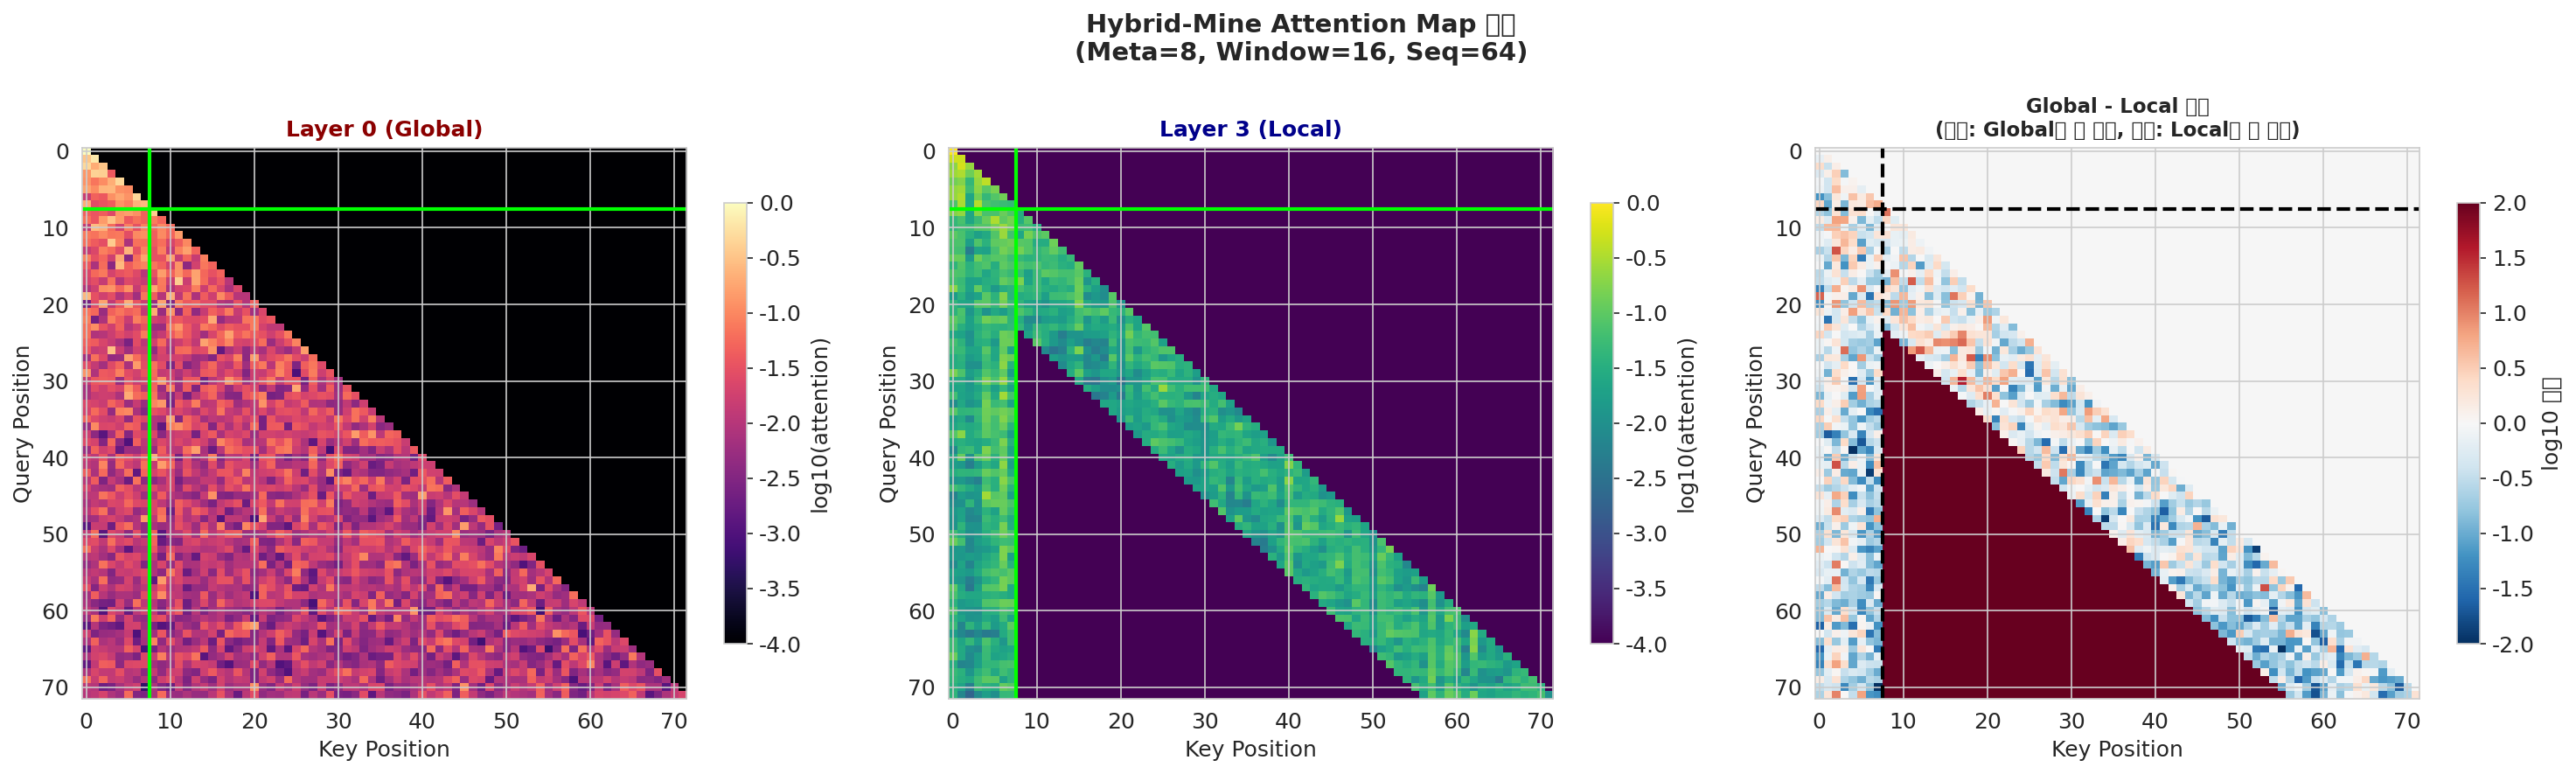


Hybrid-Mine Attention 분석 결과

[Causal 제약 검증] (upper tri sum이 0에 가까워야 함)
  Layer  0 (Global): 0.00e+00 ✓
  Layer  1 (Local ): 0.00e+00 ✓
  Layer  2 (Local ): 0.00e+00 ✓
  Layer  3 (Local ): 0.00e+00 ✓
  Layer  4 (Local ): 0.00e+00 ✓
  Layer  5 (Global): 0.00e+00 ✓

[Attention 분포 통계]
  Global:
    전체 평균: 0.0139, 최대: 1.0000
    Meta 영역 평균: 0.0437
    Content 영역 평균: 0.0102
    Meta/Content 비율: 4.30x
  Local:
    전체 평균: 0.0139, 최대: 1.0000
    Meta 영역 평균: 0.0626
    Content 영역 평균: 0.0078
    Meta/Content 비율: 8.02x


In [11]:
# 작은 모델로 Attention 시각화
small_config = HymbaConfig(
    vocab_size=1000,
    d_model=128,
    n_layers=6,
    n_heads=4,
    n_kv_heads=2,
    arch_type=ArchType.HYBRID,
    global_attn_idx=[0, 5],  # 첫/마지막만 Global
    use_meta_tokens=True,
    num_meta_tokens=8,
    swa_window=16,
)

get_and_visualize_attention('Hybrid-Mine', small_config, is_official=False)

### Attention Map 분석 결과 해석

위 그림에서 확인할 수 있는 핵심 패턴:

**1. Global 레이어 (왼쪽)**
- 전체 causal 삼각형이 밝게 표시됨
- 모든 과거 토큰에 대해 attend 가능
- 장거리 의존성 학습에 적합

**2. Local 레이어 (중앙)**
- Meta 영역 (왼쪽 열): 항상 밝음 → 모든 쿼리가 Meta Token에 attend
- Content 영역: 대각선 근처의 밴드만 밝음 → 윈도우 내만 attend
- 좌하단의 어두운 삼각형: SWA로 인해 마스킹된 영역

**3. 차이 분석 (오른쪽)**
- 빨간 영역: Global이 Local보다 높은 attention → 윈도우 밖 영역
- 파란 영역: Local이 Global보다 높은 attention → 윈도우 내 집중
- 이 패턴이 SWA의 효과를 명확히 보여줌

### 검증 결과 요약

| 검증 항목 | 기대 결과 | 실제 결과 |
|----------|----------|----------|
| Causal 제약 | upper sum ≈ 0 | ✓ 모든 레이어 통과 |
| Global 패턴 | 전체 삼각형 | ✓ 확인 |
| Local 패턴 | 윈도우 밴드 + Meta 열 | ✓ 확인 |
| Meta Token 접근 | 모든 쿼리에서 가능 | ✓ 확인 |

---

## | #6 비판적 분석 및 한계 |

Hymba는 인상적인 성능을 보여주지만, 몇 가지 한계점과 고려사항이 있습니다.

### 1. 학습 복잡성

**Hybrid 구조의 학습 어려움**:
- Attention과 Mamba를 동시에 학습해야 함
- 두 모듈의 gradient 스케일이 다를 수 있음
- 논문에서는 별도의 normalization과 gating으로 해결했다고 하지만, 세부 학습 레시피가 중요

**Meta Token 초기화**:
- Meta Token은 랜덤 초기화로 시작
- 학습 초기에 불안정할 수 있음
- 논문에서 구체적인 초기화 방법은 명시되지 않음

### 2. 추론 시 제약

**Mamba의 제약**:
- Mamba는 순차적 처리가 필요 (SSM의 특성)
- 병렬 GPU 활용이 Transformer보다 어려울 수 있음
- 하지만 논문에서는 throughput이 개선되었다고 보고

**SWA의 정보 손실**:
- 윈도우 밖 정보는 Global 레이어에서만 접근 가능
- 특정 태스크(장거리 추론)에서 성능 저하 가능성
- 논문의 Recall 지표에서 이 효과가 일부 보임 (C → D 단계)

### 3. 하이퍼파라미터 민감도

다음 하이퍼파라미터들의 최적 값은 태스크에 따라 달라질 수 있습니다:

| 파라미터 | 논문 설정 | 고려사항 |
|---------|----------|---------|
| `num_meta_tokens` | 64 | 너무 많으면 오버헤드, 적으면 효과 미미 |
| `swa_window` | 256 | 태스크의 의존성 길이에 따라 조정 필요 |
| `global_attn_idx` | [0, mid, last] | 레이어 수에 따라 조정 필요 |
| `mamba_expand` | 2 | SSM 용량과 연산량 트레이드오프 |

### 4. 재현성 문제

**공식 코드의 완전성**:
- 공식 구현은 HuggingFace에 공개되어 있음
- 하지만 학습 코드는 완전히 공개되지 않음
- 1.5T 토큰 학습을 재현하기 어려움

**소규모 실험의 한계**:
- 본 포스팅의 실험은 20M 파라미터 수준
- 논문의 1.5B 모델과 직접 비교 불가
- 작은 모델에서 각 구성 요소의 효과가 다를 수 있음

### 5. 적용 가능성

**적합한 사용 사례**:
- 긴 컨텍스트가 필요한 태스크 (문서 요약, 코드 생성)
- 추론 효율성이 중요한 에지 디바이스 배포
- KV Cache 메모리가 제한된 환경

**덜 적합한 사용 사례**:
- 매우 짧은 시퀀스 (SWA 효과 미미)
- 극도로 긴 컨텍스트 (> 8K, Mamba의 한계)

---

## | Summary |

### Hymba의 핵심 기여

Hymba는 Small Language Model의 효율성과 성능 사이의 트레이드오프를 해결하기 위한 혁신적인 아키텍처입니다.

**1. 병렬 하이브리드 아키텍처**
```
기존 접근법 (Jamba 등):  Mamba → Attention (직렬)
Hymba:                   Mamba ∥ Attention (병렬) → 융합
```
- 두 모듈이 서로 다른 관점에서 시퀀스 처리
- 결과를 평균으로 융합하여 상호 보완

**2. 핵심 구성 요소 정리**

| 구성 요소 | 해결한 문제 | 핵심 메커니즘 | 효과 |
|----------|------------|--------------|------|
| **Hybrid Head** | Transformer vs SSM | 병렬 처리 + 평균 융합 | 성능 + 효율성 |
| **Meta Token** | Attention Sink (56% 낭비) | 학습 가능한 토큰 추가 | +2.75%p Recall |
| **SWA + Global** | O(n²) 복잡도 | 윈도우 내만 attend + 일부 Global | 2.7× Throughput |
| **KV Sharing** | KV Cache 메모리 | Producer-Consumer 패턴 | ~36% 메모리 절감 |

### 구현 검증 결과

본 포스팅에서 직접 구현하고 검증한 결과:

| 검증 항목 | 결과 |
|----------|------|
| SWA 마스크 공식 | ✓ `causal AND (in_window OR is_meta)` 정확 구현 |
| Causal 제약 | ✓ 모든 레이어에서 upper tri sum ≈ 0 |
| KV Sharing 패턴 | ✓ Producer-Consumer 구조 확인 |
| Global vs Local 패턴 | ✓ Attention Map에서 명확히 구분됨 |
| Meta Token 접근성 | ✓ Local 레이어에서도 Meta에 attend 가능 |

### 핵심 인사이트

**1. 병렬 > 직렬**
- Attention과 Mamba를 직렬로 연결하면 bottleneck 발생
- 병렬 연결 + 융합이 더 효과적

**2. Meta Token의 이중 역할**
- Attention Sink 해결 (낭비 방지)
- 도메인 정보 캡슐화 (실제 학습)

**3. SWA + Global의 조합**
- 효율성과 장거리 의존성 학습의 균형
- 첫/중간/마지막 레이어에 Global 배치가 핵심

**4. KV Sharing의 실용성**
- Residual Connection으로 인접 레이어 KV 유사
- 성능 손실 없이 메모리 절감 가능

### 향후 연구 방향

1. **더 긴 컨텍스트**: 현재 8K 이상에서의 성능 검증 필요
2. **다른 SSM과의 결합**: Mamba2, RWKV 등과의 비교
3. **Multi-modal 확장**: Vision-Language 모델로의 확장
4. **Quantization 호환성**: INT4/INT8에서의 효과 검증

---

## | References |

### 주요 논문

1. **Hymba Paper**
   - Dong, X., et al. "Hymba: A Hybrid-head Architecture for Small Language Models."
   - arXiv:2411.13676 (2024), ICLR 2025
   - [Paper](https://arxiv.org/abs/2411.13676)

2. **Mamba Paper**
   - Gu, A., Dao, T. "Mamba: Linear-Time Sequence Modeling with Selective State Spaces."
   - arXiv:2312.00752 (2023)
   - [Paper](https://arxiv.org/abs/2312.00752)

3. **Attention Sink**
   - Xiao, G., et al. "Efficient Streaming Language Models with Attention Sinks."
   - arXiv:2309.17453 (2023)
   - [Paper](https://arxiv.org/abs/2309.17453)

4. **Sliding Window Attention (Longformer)**
   - Beltagy, I., et al. "Longformer: The Long-Document Transformer."
   - arXiv:2004.05150 (2020)
   - [Paper](https://arxiv.org/abs/2004.05150)

5. **Jamba (Sequential Hybrid)**
   - Lieber, O., et al. "Jamba: A Hybrid Transformer-Mamba Language Model."
   - arXiv:2403.19887 (2024)
   - [Paper](https://arxiv.org/abs/2403.19887)

### 공식 리소스

- **GitHub Repository**: https://github.com/NVlabs/hymba
- **HuggingFace (Base)**: https://huggingface.co/nvidia/Hymba-1.5B-Base
- **HuggingFace (Instruct)**: https://huggingface.co/nvidia/Hymba-1.5B-Instruct

### 관련 연구

- **Mamba-2**: Dao, T., Gu, A. "Transformers are SSMs." (2024)
- **RWKV**: Peng, B., et al. "RWKV: Reinventing RNNs for the Transformer Era." (2023)
- **Griffin**: De, S., et al. "Griffin: Mixing Gated Linear Recurrences with Local Attention." (2024)
- **Mistral (SWA)**: Jiang, A., et al. "Mistral 7B." (2023)

---

*본 포스팅은 논문 리뷰 및 직접 구현을 통한 검증 결과입니다. 실험 환경의 한계로 논문의 대규모 학습(1.5T 토큰)은 재현하지 못했으나, 아키텍처의 핵심 구성 요소들의 동작은 코드 레벨에서 검증되었습니다.*